# Flight Delay Analysis

The goal of this notebook is to conduct analysis and visualization on 2015 US Domestic Flight Delay dataset.

1. Load Data
2. Analysis by Airports
3. Breakdown of Departure/Arrival Delays by Airports and Airlines


#### References
* [Kaggle Dataset](https://www.kaggle.com/usdot/flight-delays/kernels)
* [Data Columns Definition](https://www.kaggle.com/usdot/flight-delays/discussion/29308)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

---
## 1. Load Data

### *Observations*

#### Airports
* There are altogether 322 aiports. Some of them are 5-digit number instead of three-character code. We have only consider airports with three-character code in this analysis.

#### Airlines
* There are 14 airlines. 

#### Flights
There are 5M+ flights, with the following data columns.

* Basic info about the flight
    * YEAR, MONTH, DAY, DAY_OF_WEEK
    * AIRLINE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT

* Departure info
    * SCHEDULED_DEPARTURE (in hh:mm)
    * DEPARTURE_TIME (in hh:mm) = wheels_off - taxi_out
    * DEPARTURE_DELAY (in minutes) = departure_time - scheduled_departure
    * TAXI_OUT (in minutes) = The time duration elapsed between departure from the origin airport gate and wheels off.
    * WHEELS_OFF (in hh:mm) = departure time + taxi_out. The time point that the aircraft's wheels leave the ground.

* Air time and distance
    * SCHEDULED_TIME (in minutes)
    * ELAPSED_TIME (in minutes) = air_time + taxi_in + taxi_out
    * AIR_TIME (in minutes) = wheels_on - wheels_off = The time duration between wheels_off and wheels_on time.
    * DISTANCE (in miles)

* Arrival info
    * WHEELS_ON (in hh:mm) = The time point that the aircraft's wheels touch on the ground.
    * TAXI_IN (in minutes) = The time duration elapsed between wheels-on and gate arrival at the destination airport.
    * SCHEDULED_ARRIVAL (in hh:mm)
    * ARRIVAL_TIME (in hh:mm) = wheels_on + taxi_in
    * ARRIVAL_DELAY (in minutes) = arrival_time - scheduled_arrival

* Flight status
    * DIVERTED
    * CANCELLED
    * CANCELLATION_REASON
    * AIR_SYSTEM_DELAY
    * SECURITY_DELAY
    * AIRLINE_DELAY
    * LATE_AIRCRAFT_DELAY
    * WEATHER_DELAY
    
Notes:
* Only cancelled flights have cancellation reason.
* Cancelled flights have no arrival delay, and we are not sure why there are 3731 of them have departure delay.
* Diverted flights have departure delay but no arrival delay.
* Only flights with ARRIVAL_DELAY >= 15min have delay breakdown.

In [2]:
# load airport data
airports = pd.read_csv('data/airports.csv')
print(airports.shape)
airports.head()

(322, 7)


,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [3]:
# load airline data
airlines = pd.read_csv('data/airlines.csv')
print(airlines.shape)
airlines.head()

(14, 2)


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [4]:
# load flight data
flights = pd.read_csv('data/flights.csv')
print(flights.shape)
# print(flights.columns)
flights.head()

/Users/sukilau/miniconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


---
## 2. Analysis by Airports

### *Summary Statistics*
* Num of departures
* Num of arrivals
* Percentage of cancelled flight = num of cancelled flights / num of departures
* Percentage of diverted flight = num of diverted flights / num of departures
* Average departure delay = sum of departure delays (in min) / num of departure delays
* Average arrival delay = sum of arrival delays (in min) / num of arrival delays


### *Breakdown by Airlines*
* Num of departures and arrivals by airlines
* Average depature delays by airlines
* Average arrival delays by airlines

In [5]:
def get_airport_stats(airport):
    '''Function to get summary statistics and breakdown by airlines for a specific airport'''

    # compute breakdown statitsics by airlines
    stats = {'arrivals':None,
             'departures':None, 
             'cancelled':None, 
             'cancelled_percent':None, 
             'diverted':None, 
             'avg_arrival_delay':None,
             'avg_departure_delay':None}
    
    gp1 = flights[flights['DESTINATION_AIRPORT']==airport].groupby('AIRLINE')
    stats['arrivals'] = gp1['FLIGHT_NUMBER'].count().reset_index().rename(columns={'FLIGHT_NUMBER': 'COUNT'})
    
    gp2 = flights[flights['ORIGIN_AIRPORT']==airport].groupby('AIRLINE')
    stats['departures'] = gp2['FLIGHT_NUMBER'].count().reset_index().rename(columns={'FLIGHT_NUMBER': 'COUNT'})
    stats['cancelled'] = gp2['CANCELLED'].sum().reset_index().rename(columns={'CANCELLED': 'COUNT'})
    stats['diverted'] = gp2['DIVERTED'].sum().reset_index().rename(columns={'DIVERTED': 'COUNT'})

    gp3 = flights[(flights['DESTINATION_AIRPORT']==airport)].groupby('AIRLINE')
    stats['avg_arrival_delay'] = gp3['ARRIVAL_DELAY'].mean().reset_index()
    
    gp4 = flights[(flights['ORIGIN_AIRPORT']==airport) & (flights['DIVERTED']==0) & (flights['CANCELLED']==0)].groupby('AIRLINE')
    stats['avg_departure_delay'] = gp4['DEPARTURE_DELAY'].mean().reset_index()
    

    # compute summary statistics
    stats_summary = {'arrivals':None,
                     'departures':None, 
                     'cancelled_percent':None,
                     'diverted_percent':None,
                     'avg_arrival_delay':None,
                     'avg_departure_delay':None
                     }
    
    stats_summary['arrivals'] =  stats['arrivals']['COUNT'].sum()
    stats_summary['departures'] =  stats['departures']['COUNT'].sum()
    stats_summary['cancelled_percent'] = (stats['cancelled']['COUNT'].sum()/stats_summary['departures']) * 100 
    stats_summary['diverted_percent'] = (stats['diverted']['COUNT'].sum()/stats_summary['departures']) * 100
    stats_summary['avg_arrival_delay'] =  flights[(flights['DESTINATION_AIRPORT']==airport)]['ARRIVAL_DELAY'].mean()
    stats_summary['avg_departure_delay'] = flights[(flights['ORIGIN_AIRPORT']==airport) & (flights['DIVERTED']==0) & (flights['CANCELLED']==0)]['DEPARTURE_DELAY'].mean()
    
    return stats, stats_summary
    

In [6]:
def plot_barchart(df, x_label, y_label, hue_label, title, color_palette):
    '''Function to plot barchart'''  
    df_sorted = df.sort_values(by=y_label, ascending=False)
    plt.figure(figsize=(9,6))
    sns.barplot(x=x_label, y=y_label, data=df_sorted, hue=hue_label, palette=color_palette)
    plt.title(title)
    plt.show()


In [7]:
def show_report(airport):
    '''Function to print summary statistics and plot charts for a specific airport'''
    stats, stats_summary = get_airport_stats(airport)
    
    # Print summary statistics
    print("===== Airport : {} ======".format(airport))
    print('{:40} : {:,}'.format('Total num of arrivals', stats_summary['arrivals']))
    print('{:40} : {:,}'.format('Total num of departures', stats_summary['departures']))
    print('{:40} : {:.2f}%'.format('Percentage of cancelled flights', stats_summary['cancelled_percent']))
    print('{:40} : {:.2f}%'.format('Percentage of diverted flights', stats_summary['diverted_percent']))
    print('{:40} : {:.2f}'.format('Average arrival delays (in minutes)', stats_summary['avg_arrival_delay']))
    print('{:40} : {:.2f}'.format('Average departure delays (in minutes)', stats_summary['avg_departure_delay']))
    
    # Plot - Num of departures and arrivals by airlines
    stats['departures']['type'] = 'departures'
    stats['arrivals']['type'] = 'arrivals'
    df = pd.concat([stats['departures'], stats['arrivals']])
    plot_barchart(df, 'AIRLINE', 'COUNT', 'type', 'Num of Departures and Arrivals by Airlines for {} Airport'.format(airport), 'RdBu')
    
    # Plot - Average departure delays by airlines
    plot_barchart(stats['avg_arrival_delay'], 'AIRLINE', 'ARRIVAL_DELAY', None, 'Average Arrival Delays (in minutes) by Airlines for {} Airport'.format(airport), 'OrRd_d')

    # Plot - Average arrival delays by airlines
    plot_barchart(stats['avg_departure_delay'], 'AIRLINE', 'DEPARTURE_DELAY', None, 'Average Departure Delays (in minutes) by Airlines for {} Airport'.format(airport), 'OrRd_d')


===== Airport : SFO ======
Total num of arrivals                    : 147,966
Total num of departures                  : 148,008
Percentage of cancelled flights          : 1.45%
Percentage of diverted flights           : 0.25%
Average arrival delays (in minutes)      : 6.58
Average departure delays (in minutes)    : 11.16


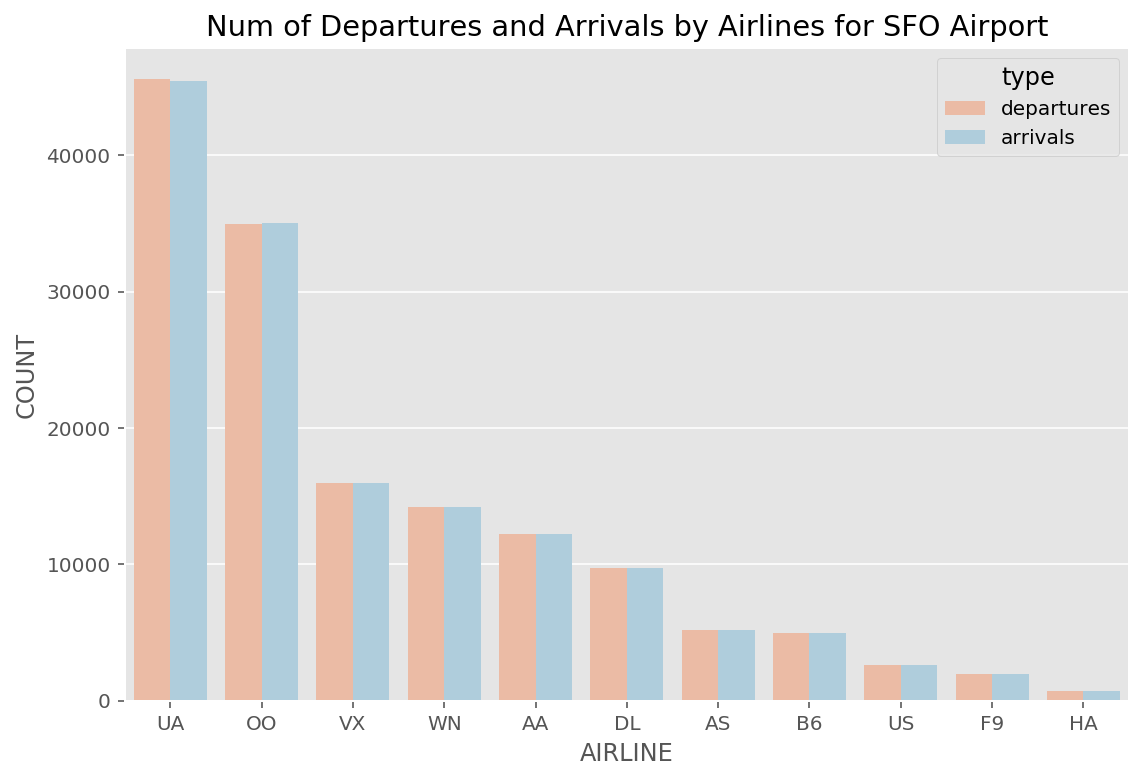

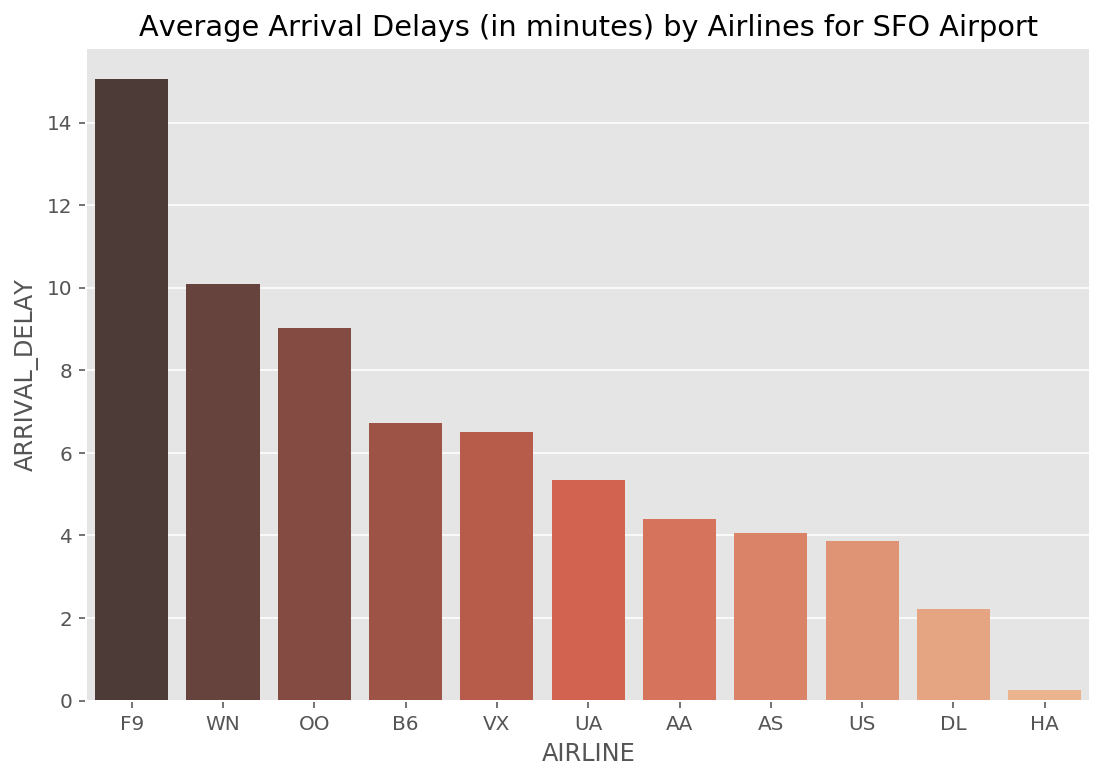

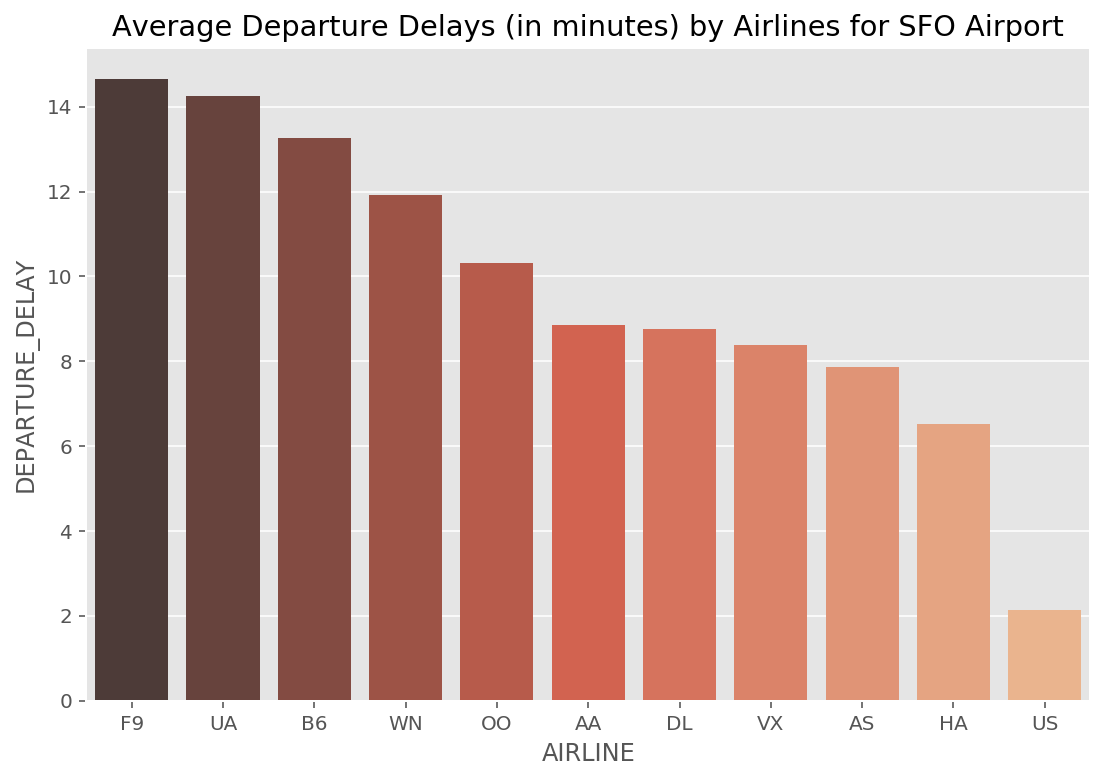

In [8]:
show_report('SFO')

---
## 3. Breakdown of Departure/Arrival Delays by Airports and Airlines

In [9]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}


def plot_ddelay_heatmap(flights): 
    '''Function to plot departure delays by origin airports and airlines'''
    
    airport_mean_delays = pd.DataFrame(pd.Series(flights['ORIGIN_AIRPORT'].unique()))
    airport_mean_delays.set_index(0, drop = True, inplace = True)

    for carrier in airlines['IATA_CODE']:
        fg1 = flights[flights['AIRLINE'] == carrier]
        test = fg1['DEPARTURE_DELAY'].groupby(flights['ORIGIN_AIRPORT']).apply(get_stats).unstack()
        airport_mean_delays[carrier] = test.loc[:, 'mean'] 

    sns.set(context="paper")
    fig = plt.figure(1, figsize=(12,18))
    fig.text(0.5, 1.02, "Departure Delays from Origin Airport", ha='center', fontsize = 20)

    for i in range(6):
        ax = fig.add_subplot(2,3,i+1)
        subset = airport_mean_delays.iloc[i*50:(i+1)*50,:]
        mask = subset.isnull()
        sns.heatmap(subset, linewidths=0.05, cmap="YlOrRd", mask=mask, vmin = 0, vmax = 30)
        plt.setp(ax.get_yticklabels(), fontsize=8)
        plt.setp(ax.get_xticklabels(), fontsize=8, rotation = 90)
        ax.yaxis.label.set_visible(False)

    plt.tight_layout()
    

def plot_adelay_heatmap(flights): 
    '''Function to plot arrival delays by destination airports and airlines'''
    
    airport_mean_delays = pd.DataFrame(pd.Series(flights['DESTINATION_AIRPORT'].unique()))
    airport_mean_delays.set_index(0, drop = True, inplace = True)

    for carrier in airlines['IATA_CODE']:
        fg1 = flights[flights['AIRLINE'] == carrier]
        test = fg1['ARRIVAL_DELAY'].groupby(flights['DESTINATION_AIRPORT']).apply(get_stats).unstack()
        airport_mean_delays[carrier] = test.loc[:, 'mean'] 

    sns.set(context="paper")
    fig = plt.figure(1, figsize=(12,18))
    fig.text(0.5, 1.02, "Arrival Delays to Destination Airport", ha='center', fontsize = 20)

    for i in range(6):
        ax = fig.add_subplot(2,3,i+1)
        subset = airport_mean_delays.iloc[i*50:(i+1)*50,:]
        mask = subset.isnull()
        sns.heatmap(subset, linewidths=0.05, cmap="YlOrRd", mask=mask, vmin = 0, vmax = 30)
        plt.setp(ax.get_yticklabels(), fontsize=8)
        plt.setp(ax.get_xticklabels(), fontsize=8, rotation = 90)
        ax.yaxis.label.set_visible(False)

    plt.tight_layout()

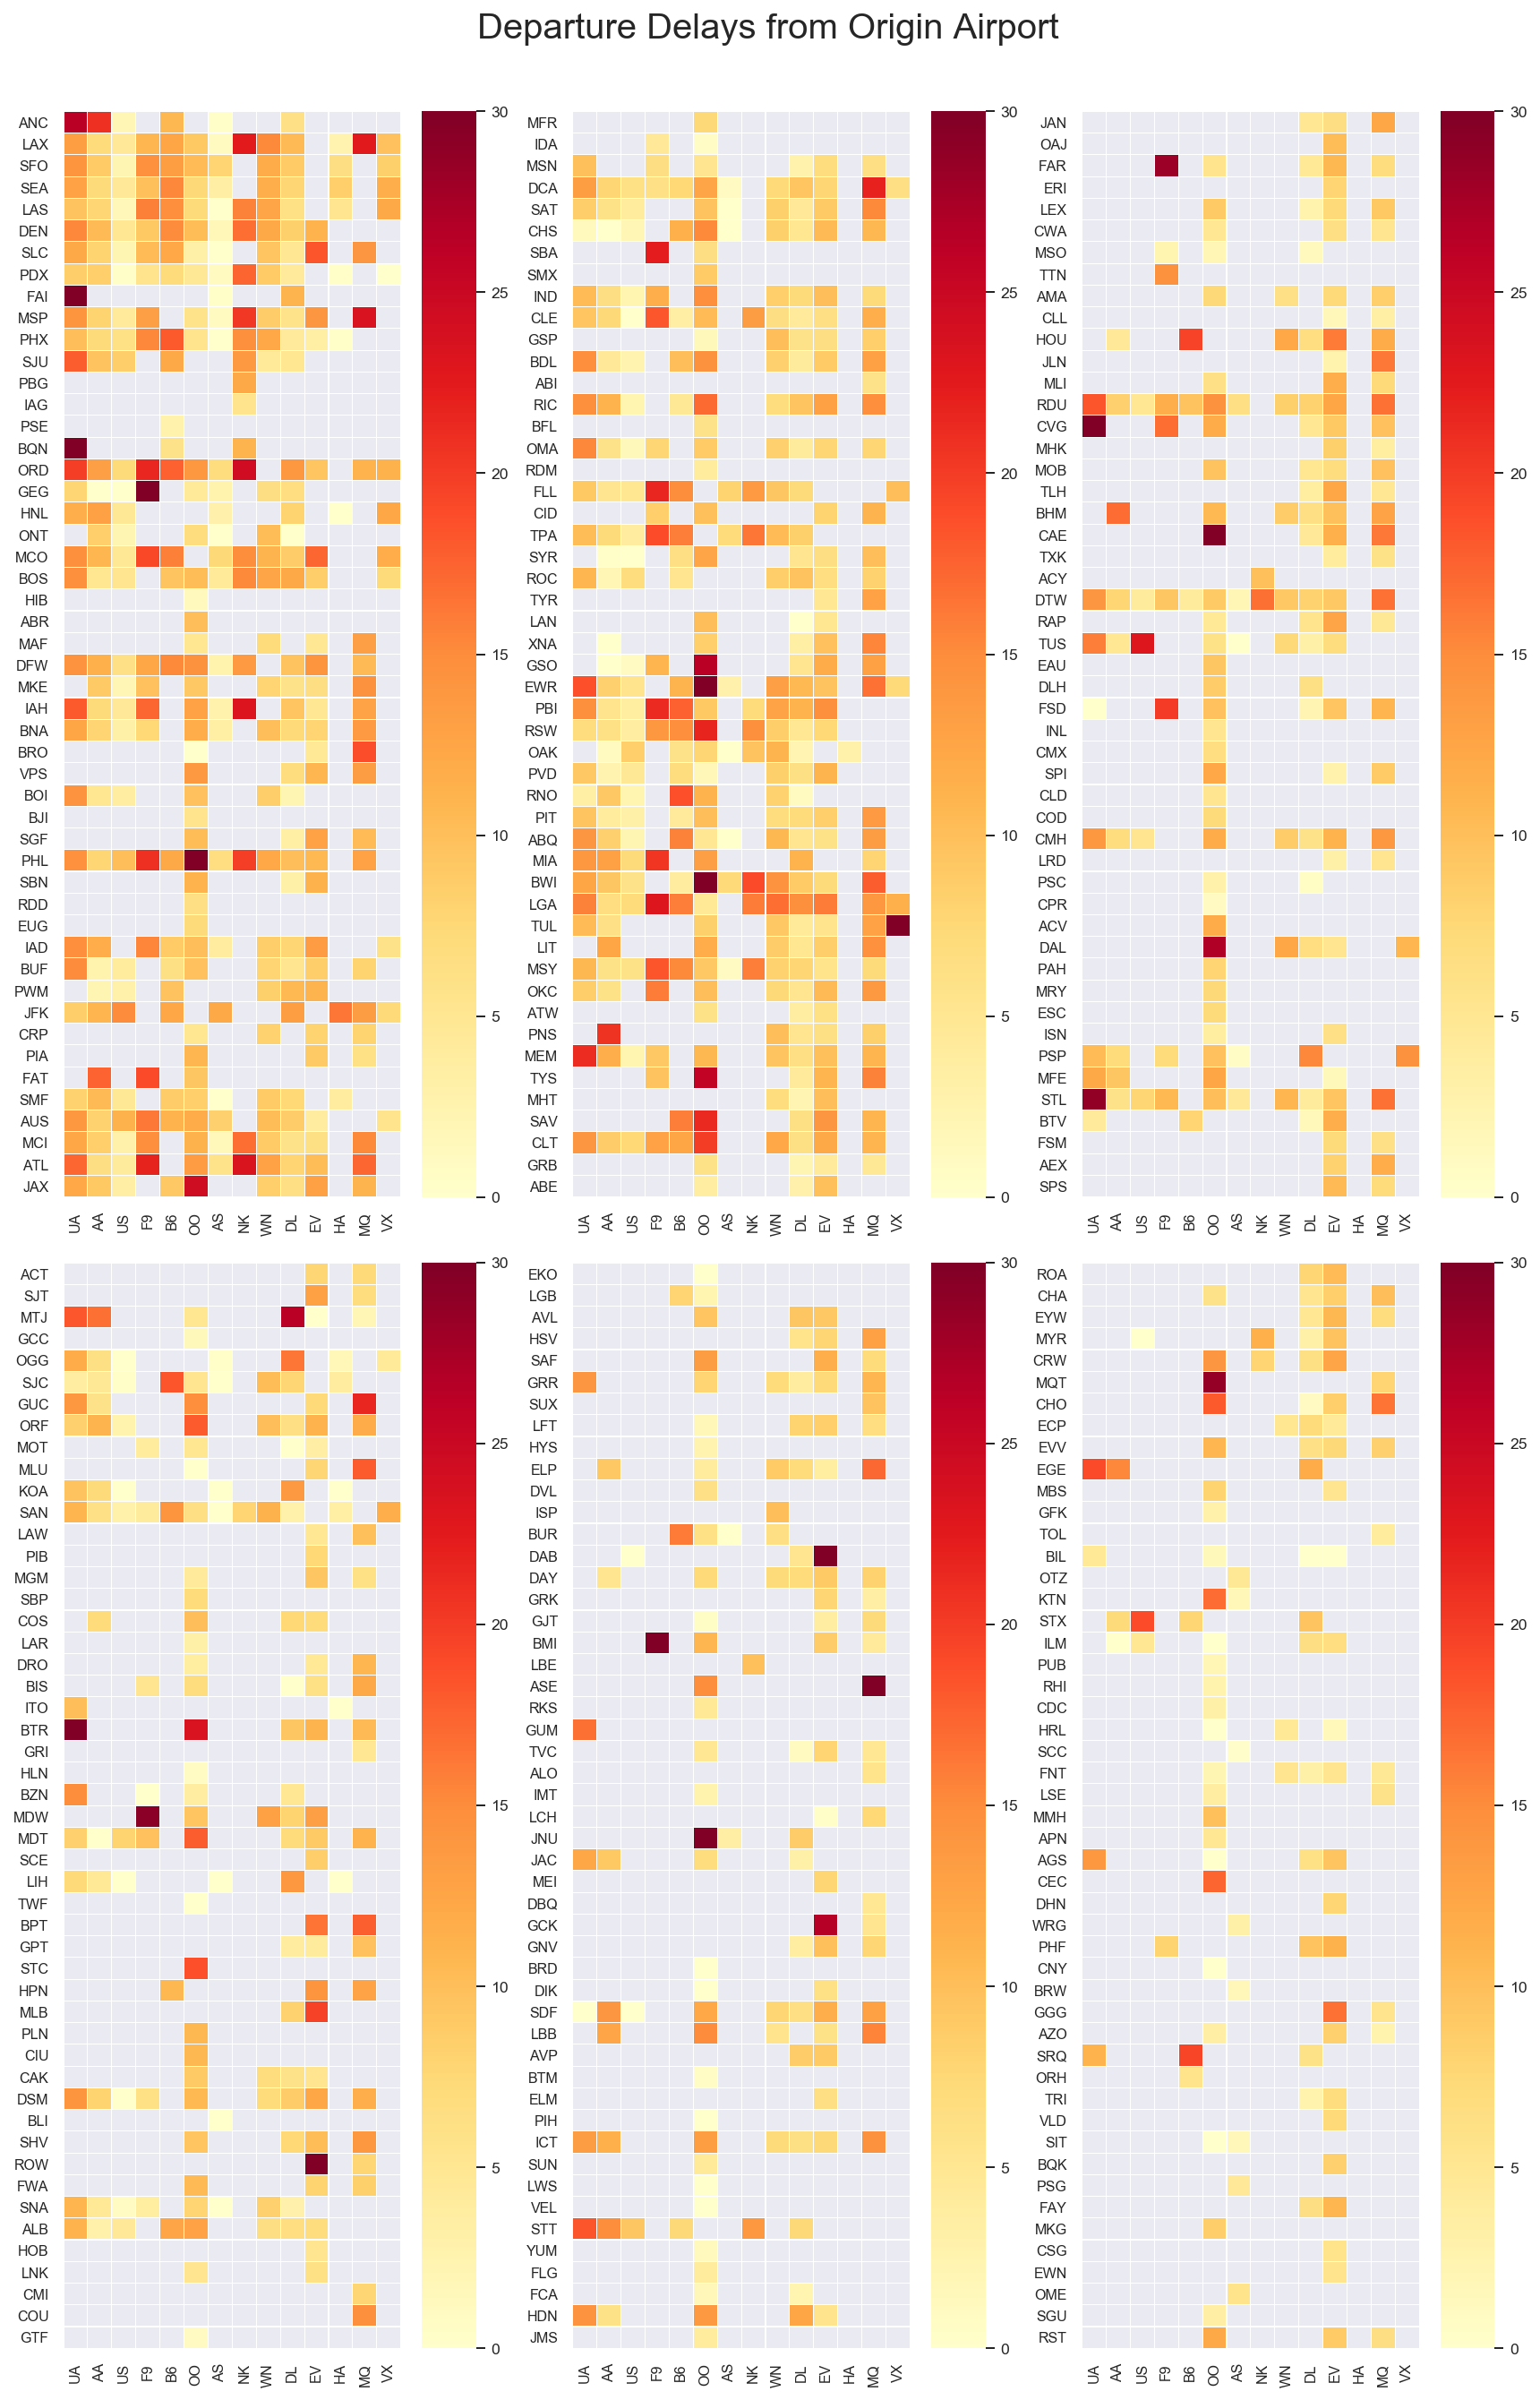

In [10]:
plot_ddelay_heatmap(flights)

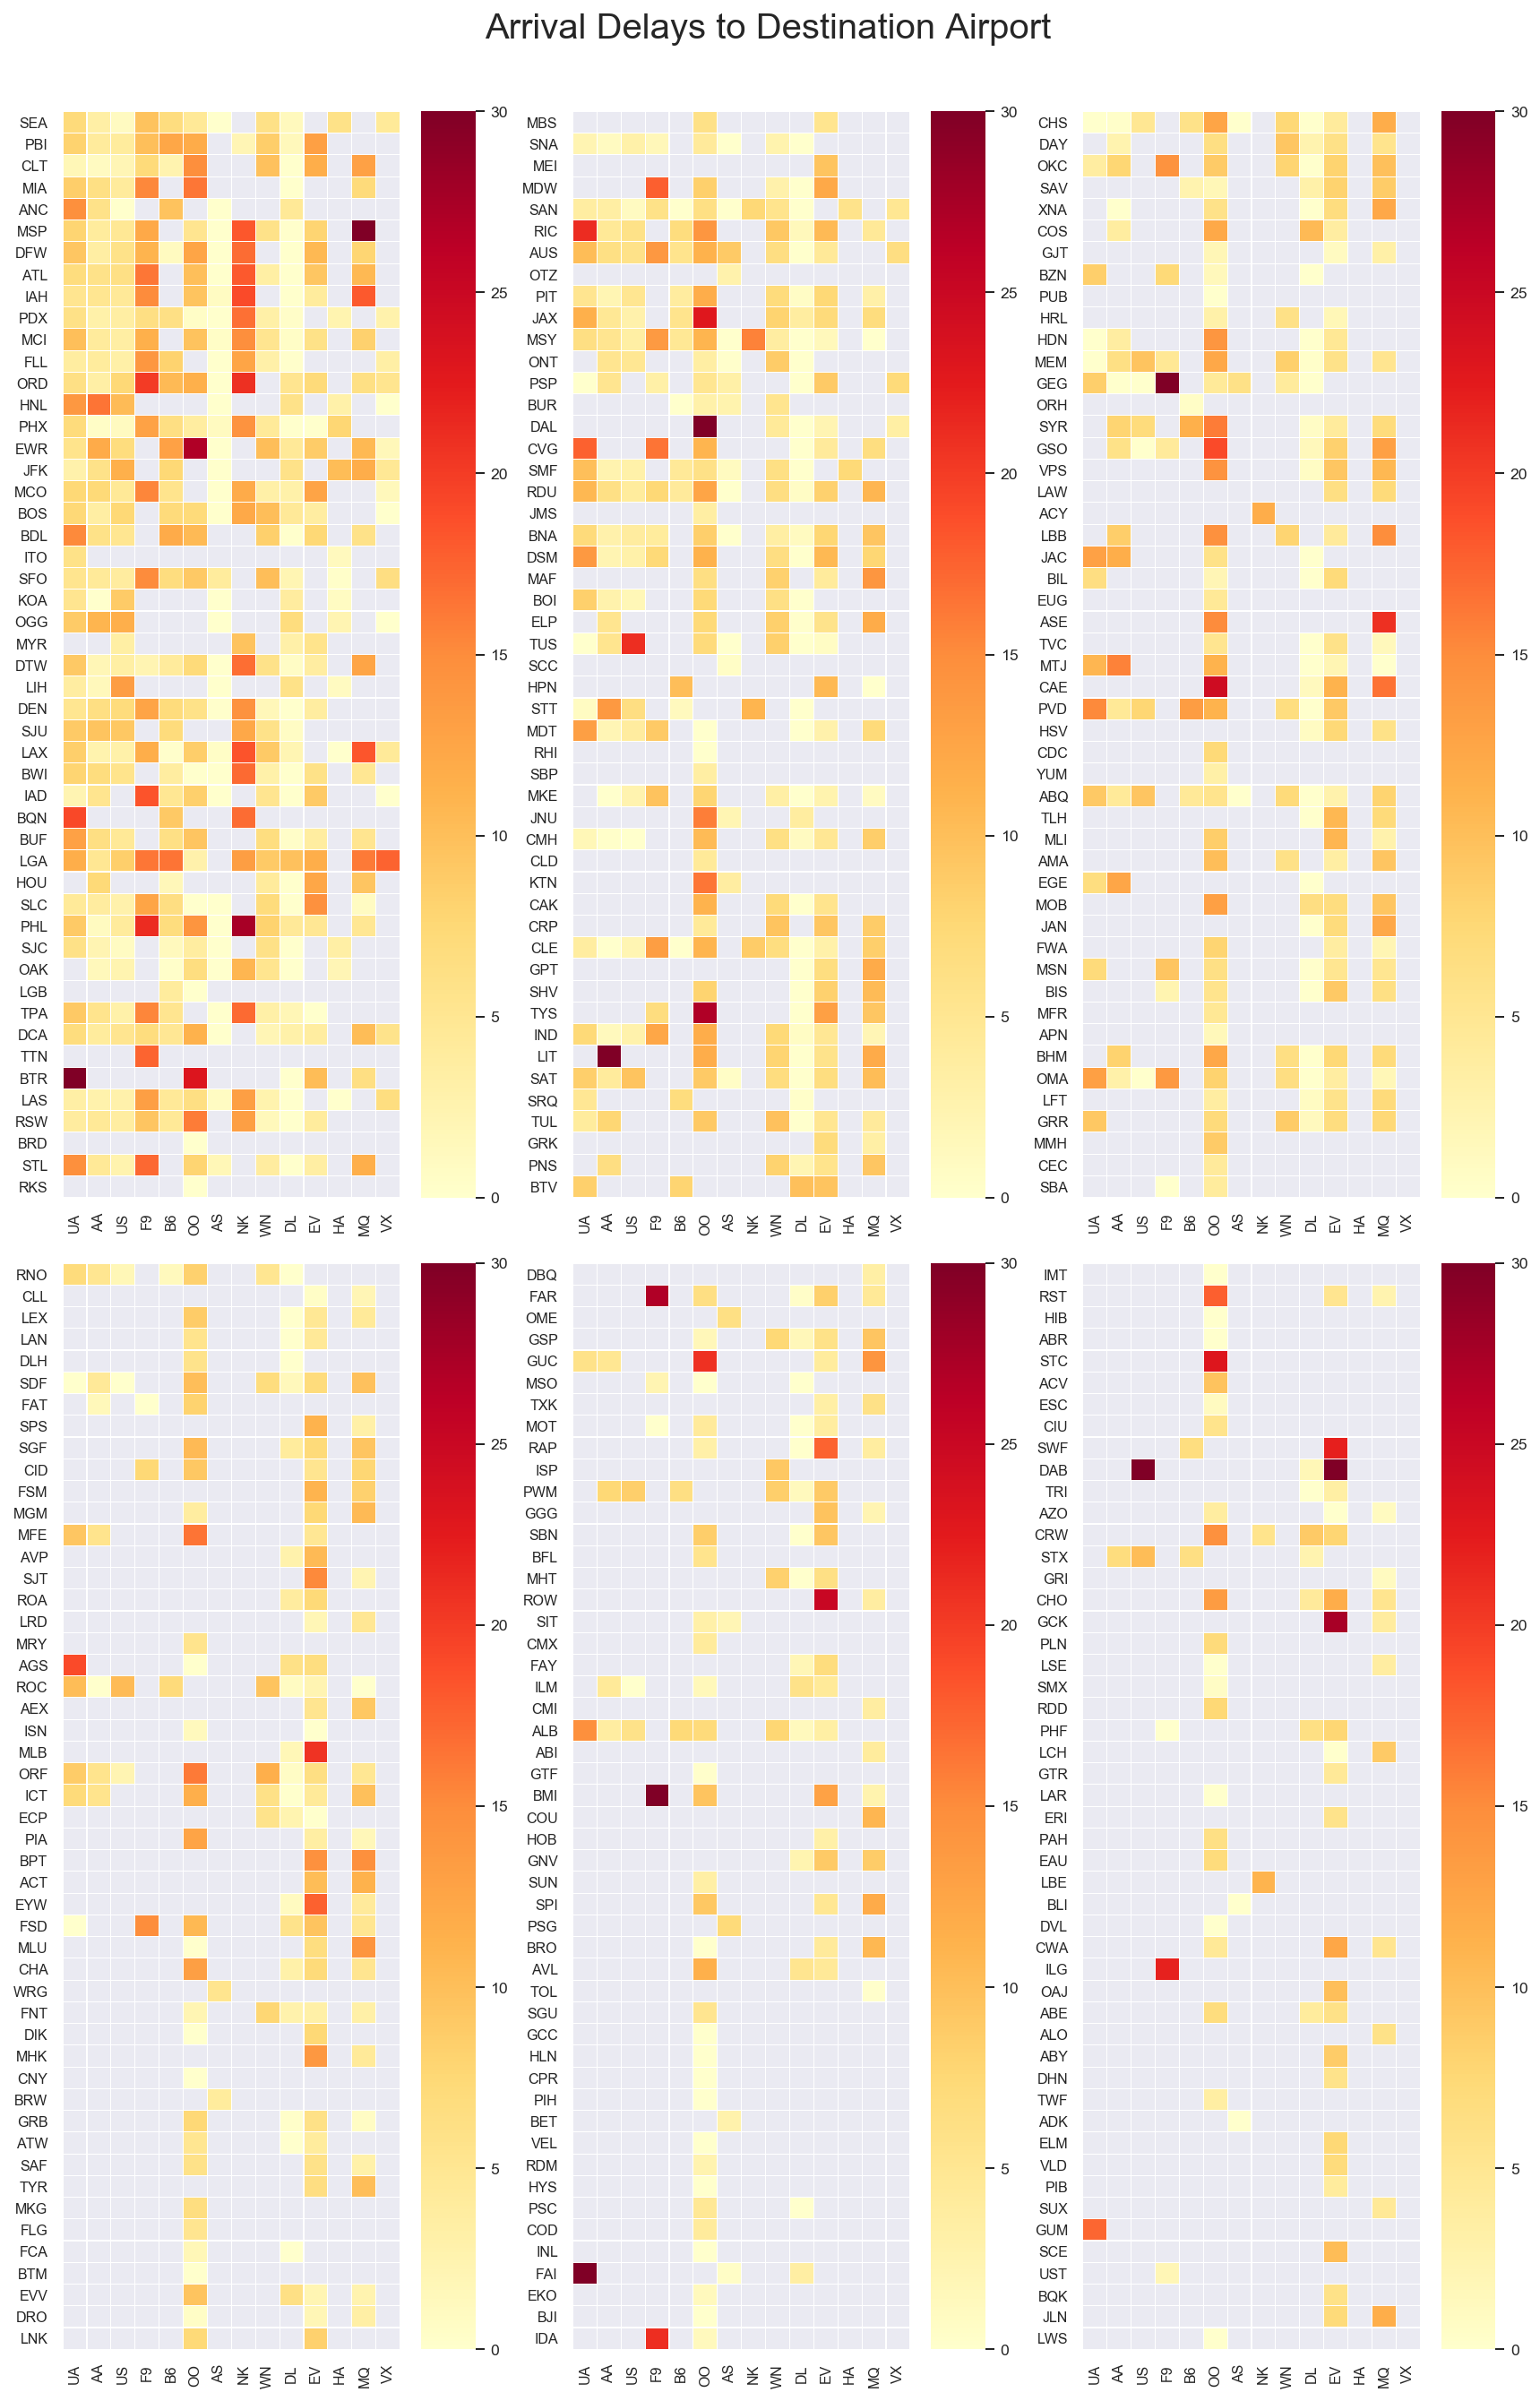

In [11]:
plot_adelay_heatmap(flights)